# <Center> Gerrymandering Integer Programming

### Notebook follows example found at this link: https://ocw.mit.edu/courses/sloan-school-of-management/15-071-the-analytics-edge-spring-2017/integer-optimization/assignment-9/gerrymandering-new-mexico/

In [53]:
import numpy as np
import cvxpy
from cvxpy import *
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx 
import geopandas as gpd 
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [54]:
#Import Data
df = pd.read_excel('GerrymanderingData.xlsx', index_col=0)
#Fill empty district values with 0
df = df.fillna(0)
df.head()

,County,District 1,District 2,District 3,Scenario 1 (D_j - R_j),Scenario 2 (D_j - R_j),Scenario 3 (D_j - R_j)
County Num,,,,,,,
1,Bernalillo,1.0,0.0,0.0,42941,43411,11336
2,Catron,0.0,1.0,0.0,-917,18,-716
3,Chaves,0.0,1.0,0.0,-6650,-6244,-6436
4,Cibola,0.0,1.0,0.0,1941,1449,1025
5,Colfax,0.0,0.0,1.0,116,-871,-1099


In [55]:
#Create Array of Original Disctricts, using 1-2-3 for indication of district
d1 = df['District 1'].values
d2 = df['District 2'].values*2
d3 = df['District 3'].values*3
og_district = d1+d2+d3

In [56]:
#Import New Mexico Shape data into geopandas (changefile path)
path = "/Users/davisgiles/Desktop/Engineering/Python/Data Science Exercises/Gerrymandering/tl_2010_35_county10_shp/tl_2010_35_county10.shp"
geo_df = gpd.read_file(path)
geo_df = geo_df.to_crs("EPSG:4326")

#Sort by name, store original district values & results
geo_df = geo_df.sort_values('NAME10')
geo_df['OG District'] = og_district
geo_df['Results 1'] = df['Scenario 1 (D_j - R_j)'].values
geo_df['Results 2'] = df['Scenario 2 (D_j - R_j)'].values
geo_df['Results 3'] = df['Scenario 3 (D_j - R_j)'].values

In [57]:
def plot_map(col, title, ticks=False):
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    if ticks:
        geo_df.plot(column=col, ax=ax, legend=True,legend_kwds={'ticks':ticks,'label': "District",'orientation': "vertical"}, cmap='RdBu', edgecolor='black')
    else:
        geo_df.plot(column=col, ax=ax, legend=True,legend_kwds={'label': "Margin (D_j - R_j)",'orientation': "vertical"}, cmap='viridis', edgecolor='black')
    plt.title(title)
    ax.set_axis_off()

In [58]:
def get_num_counties(x):
    county = 0
    district_array = x.value
    for i in np.arange(33):
        county += district_array[i]
    return county

# <center> Original Districting and Scenario 1 Voting Margin Map

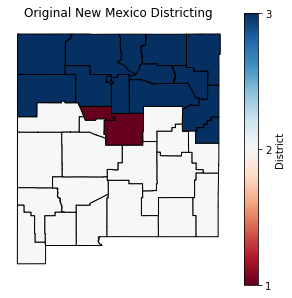

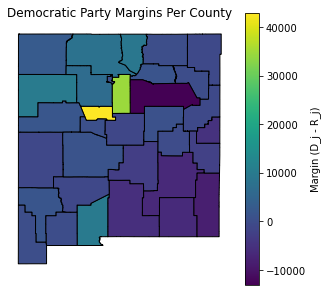

In [59]:
plot_map('OG District', 'Original New Mexico Districting', [1,2,3])
plot_map('Results 1', 'Democratic Party Margins Per County')

# <center> Problem 2.1

In [60]:
# Difference of Democrat to Republican votes per county
Dj_Rj = df['Scenario 1 (D_j - R_j)'].values
# Create optimization variables
# 3 districts with 33 counties total
x1 = Variable(33, boolean=True)
x2 = Variable(33, boolean=True)
x3 = Variable(33, boolean=True)

# Max {votes per county * counties in district 2}
objective = Maximize(Dj_Rj.T@x2)

# Subject to:
# Districts 1 and 3 win by at least 100 votes
constraints = [x1@Dj_Rj.T >=100]
constraints += [x3@Dj_Rj.T >=100]
# Each district has at least 1 county
constraints += [sum(x1) >=1]
constraints += [sum(x2) >=1]
constraints += [sum(x3) >=1]
# Each county can only be in one district
for i in np.arange(33):
    constraints += [x1[i]+x2[i]+x3[i] == 1]

#Solve objective Function
sol = Problem(objective, constraints)
sol.solve()

76197.0

Long-step dual simplex will be used


In [61]:
# Output Results
print("------------------- 2.1 Solution --------------------")
print("--------------------------------------------------")
print(f"{sol.status}\n")
print(f"District 1 Votes : {x1.value@Dj_Rj}")
print(f"District 2 Votes : {x2.value@Dj_Rj}")
print(f"District 3 Votes : {x3.value@Dj_Rj}\n")
print(f"Counties in District 1 = {get_num_counties(x1)}")
print(f"Counties in District 2 = {get_num_counties(x2)}")
print(f"Counties in District 3 = {get_num_counties(x3)}")

------------------- 2.1 Solution --------------------
--------------------------------------------------
optimal

District 1 Votes : 100.0
District 2 Votes : 76197.0
District 3 Votes : 100.0

Counties in District 1 = 13.0
Counties in District 2 = 7.0
Counties in District 3 = 13.0


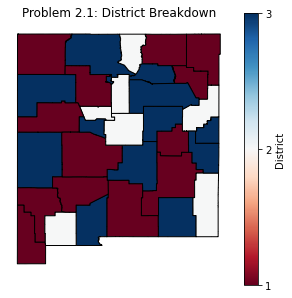

In [62]:
# Plot New Districting 
d1 = x1.value
d2 = x2.value*2
d3 = x3.value*3
district = d1+d2+d3
geo_df['2.1 District'] = district
plot_map('2.1 District', 'Problem 2.1: District Breakdown', [1,2,3])

# <center> Problem 2.3

In [63]:
# Difference of Democrat to Republican votes per county
Dj_Rj = df['Scenario 1 (D_j - R_j)'].values
# Store original districts
d1 = df['District 1'].values
d2 = df['District 2'].values
d3 = df['District 3'].values
# Create optimization variables
# 3 districts with 33 counties total
x1 = Variable(33, boolean=True)
x2 = Variable(33, boolean=True)
x3 = Variable(33, boolean=True)

# Max {Original District * New District}
objective = Maximize(d1.T@x1+d2.T@x2+d3.T@x3)
# Subject to:
# Districts 1,2,3 win by at least 100 votes
constraints += [x1@Dj_Rj.T >= 100]
constraints = [x2@Dj_Rj.T >= 100]
constraints += [x3@Dj_Rj.T >= 100]
# Each district has at least 1 county
constraints += [sum(x1) >=1]
constraints += [sum(x2) >=1]
constraints += [sum(x3) >=1]
# Each county can only be in one district
for i in np.arange(33):
    constraints += [x1[i]+x2[i]+x3[i] == 1]

# Solve objective Function
sol = Problem(objective, constraints)
sol.solve()

32.0

Long-step dual simplex will be used


In [64]:
# Output Results
print("------------------- 2.3 Solution --------------------")
print("--------------------------------------------------")
print(f"{sol.status}\n")
print(f"District 1 Votes : {x1.value@Dj_Rj}")
print(f"District 2 Votes : {x2.value@Dj_Rj}")
print(f"District 3 Votes : {x3.value@Dj_Rj}\n")
print(f"Counties in District 1 = {get_num_counties(x1)}")
print(f"Counties in District 2 = {get_num_counties(x2)}")
print(f"Counties in District 3 = {get_num_counties(x3)}")

------------------- 2.3 Solution --------------------
--------------------------------------------------
optimal

District 1 Votes : 41834.0
District 2 Votes : 16330.0
District 3 Votes : 18233.0

Counties in District 1 = 2.0
Counties in District 2 = 18.0
Counties in District 3 = 13.0


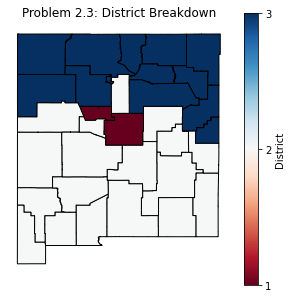

In [65]:
# Plot new districting 
d1 = x1.value
d2 = x2.value*2
d3 = x3.value*3
district = d1+d2+d3
geo_df['2.3 District'] = district
plot_map('2.3 District', 'Problem 2.3: District Breakdown', [1,2,3])

In [66]:
# Determine which counties changed from original districting
county_change = np.array(geo_df['2.3 District'] - og_district)
result = np.where(county_change !=0)
print(result)

(array([26]),)


In [67]:
# Locate index provided above
print(df['County'].iloc[26])

Santa Fe


# <center> Problem 3.3

In [68]:
# Difference of Democrat to Republican votes per county
Dj_Rj = df['Scenario 1 (D_j - R_j)'].values
# Store original districts
d1 = df['District 1'].values
d2 = df['District 2'].values
d3 = df['District 3'].values
# Create optimization variables
# 3 districts with 33 counties total
x1 = Variable(33, boolean=True)
x2 = Variable(33, boolean=True)
x3 = Variable(33, boolean=True)

# Max {Original District * New District}
objective = Maximize(d1.T@x1+d2.T@x2+d3.T@x3)
# Subject to:
# Districts 1,2,3 win by at least 100 votes
constraints += [x1@Dj_Rj.T >= 100]
constraints = [x2@Dj_Rj.T >= 100]
constraints += [x3@Dj_Rj.T >= 100]
# Each district has at least 1 county
constraints += [sum(x1) >=1]
constraints += [sum(x2) >=1]
constraints += [sum(x3) >=1]
#Both Socorro (county 29) and Torrance (county 31) must be in the same district
constraints += [x1[28]+2*x2[28]+3*x3[28] == x1[30]+2*x2[30]+3*x3[30]]
# Exactly one of Santa Fe (county 27) or Dona Ana (county 8) must be in district 2
constraints += [x2[26] + x2[7] == 1]
# Each county can only be in one district
for i in np.arange(33):
    constraints += [x1[i]+x2[i]+x3[i] == 1]

# Solve objective function
sol = Problem(objective, constraints)
sol.solve()

31.0

Long-step dual simplex will be used


In [69]:
# Output Results
print("------------------- 3.3 Solution --------------------")
print("--------------------------------------------------")
print(f"{sol.status}\n")
print(f"District 1 Votes : {x1.value@Dj_Rj}")
print(f"District 2 Votes : {x2.value@Dj_Rj}")
print(f"District 3 Votes : {x3.value@Dj_Rj}\n")
print(f"Counties in District 1 = {get_num_counties(x1)}")
print(f"Counties in District 2 = {get_num_counties(x2)}")
print(f"Counties in District 3 = {get_num_counties(x3)}")

------------------- 3.3 Solution --------------------
--------------------------------------------------
optimal

District 1 Votes : 178.0
District 2 Votes : 23463.0
District 3 Votes : 52756.0

Counties in District 1 = 2.0
Counties in District 2 = 17.0
Counties in District 3 = 14.0


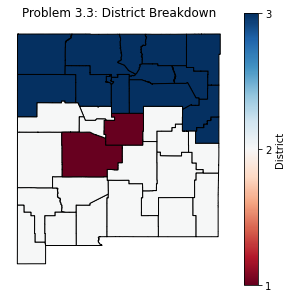

In [70]:
# Plot new districting
d1 = x1.value
d2 = x2.value*2
d3 = x3.value*3
district = d1+d2+d3
geo_df['3.3 District'] = district
plot_map('3.3 District', 'Problem 3.3: District Breakdown', [1,2,3])

In [71]:
# Determine which counties changed from original districting
county_change = np.array(geo_df['3.3 District'] - og_district)
result = np.where(county_change !=0)
print(result)

(array([ 0, 28]),)


In [72]:
# Locate indices provided above
print(df['County'].iloc[0])
print(df['County'].iloc[28])

Bernalillo
Socorro


# <center> Problem 4.1

In [73]:
# Difference of Democrat to Republican votes per county
Dj_Rj = df['Scenario 2 (D_j - R_j)'].values
# Store original districts
d1 = df['District 1'].values
d2 = df['District 2'].values
d3 = df['District 3'].values
# Create optimization variables
# 3 districts with 33 counties total
x1 = Variable(33, boolean=True)
x2 = Variable(33, boolean=True)
x3 = Variable(33, boolean=True)

# Max {Original District * New District}
objective = Maximize(d1.T@x1+d2.T@x2+d3.T@x3)
# Subject to:
# Districts 1,2,3 win by at least 100 votes
constraints += [x1@Dj_Rj.T >= 100]
constraints = [x2@Dj_Rj.T >= 100]
constraints += [x3@Dj_Rj.T >= 100]
# Each district has at least 1 county
constraints += [sum(x1) >=1]
constraints += [sum(x2) >=1]
constraints += [sum(x3) >=1]
#Both Socorro (county 29) and Torrance (county 31) must be in the same district
constraints += [x1[28]+2*x2[28]+3*x3[28] == x1[30]+2*x2[30]+3*x3[30]]
# Exactly one of Santa Fe (county 27) or Dona Ana (county 8) must be in district 2
constraints += [x2[26] + x2[7] == 1]
# Each county can only be in one district
for i in np.arange(33):
    constraints += [x1[i]+x2[i]+x3[i] == 1]

# Solve objective function
sol = Problem(objective, constraints)
sol.solve()

31.0

Long-step dual simplex will be used


In [74]:
# Output Results
print("------------------- 4.1 Solution --------------------")
print("--------------------------------------------------")
print(f"{sol.status}\n")
print(f"District 1 Votes : {x1.value@Dj_Rj}")
print(f"District 2 Votes : {x2.value@Dj_Rj}")
print(f"District 3 Votes : {x3.value@Dj_Rj}\n")
print(f"Counties in District 1 = {get_num_counties(x1)}")
print(f"Counties in District 2 = {get_num_counties(x2)}")
print(f"Counties in District 3 = {get_num_counties(x3)}")

------------------- 4.1 Solution --------------------
--------------------------------------------------
optimal

District 1 Votes : -489.0
District 2 Votes : 24899.0
District 3 Votes : 51662.0

Counties in District 1 = 2.0
Counties in District 2 = 17.0
Counties in District 3 = 14.0


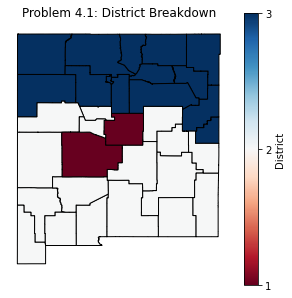

In [75]:
d1 = x1.value
d2 = x2.value*2
d3 = x3.value*3
district = d1+d2+d3
geo_df['4.1 District'] = district
plot_map('4.1 District', 'Problem 4.1: District Breakdown', [1,2,3])

In [76]:
# Determine which counties changed from original districting
county_change = np.array(geo_df['4.1 District'] - og_district)
result = np.where(county_change !=0)
print(result)

(array([ 0, 28]),)


In [77]:
# Locate indices provided above
print(df['County'].iloc[0])
print(df['County'].iloc[28])

Bernalillo
Socorro


# <center> Problem 4.2

In [78]:
# Difference of Democrat to Republican votes per county
scenario1 = df['Scenario 1 (D_j - R_j)'].values
scenario2 = df['Scenario 2 (D_j - R_j)'].values
scenario3 = df['Scenario 3 (D_j - R_j)'].values
# Store original districts
d1 = df['District 1'].values
d2 = df['District 2'].values
d3 = df['District 3'].values
# Create optimization variables
# 3 districts with 33 counties total
x1 = Variable(33, boolean=True)
x2 = Variable(33, boolean=True)
x3 = Variable(33, boolean=True)

# Max {Original District * New District}
objective = Maximize(d1.T@x1+d2.T@x2+d3.T@x3)
# Subject to:
# Districts 1,2,3 win by at least 12000 votes
constraints = [x1@scenario1.T >= 12000]
constraints += [x2@scenario1.T >= 12000]
constraints += [x3@scenario1.T >= 12000]
constraints += [x1@scenario2.T >= 12000]
constraints += [x2@scenario2.T >= 12000]
constraints += [x3@scenario2.T >= 12000]
constraints += [x1@scenario3.T >= 12000]
constraints += [x2@scenario3.T >= 12000]
constraints += [x3@scenario3.T >= 12000]
# Each district has at least 1 county
constraints += [sum(x1) >=1]
constraints += [sum(x2) >=1]
constraints += [sum(x3) >=1]
#Both Socorro (county 29) and Torrance (county 31) must be in the same district
constraints += [x1[28]+2*x2[28]+3*x3[28] == x1[30]+2*x2[30]+3*x3[30]]
# Exactly one of Santa Fe (county 27) or Dona Ana (county 8) must be in district 2
constraints += [x2[26] +x2[7] == 1]
# Each county can only be in one district
for i in np.arange(33):
    constraints += [x1[i]+x2[i]+x3[i] == 1]

# Solve objective function
sol = Problem(objective, constraints)
sol.solve()

29.0

Long-step dual simplex will be used


In [79]:
# Output Results
print("------------------- 4.2 Solution --------------------")
print("--------------------------------------------------")
print(f"{sol.status}\n")
print("Scenario 1 Results")
print(f"District 1 Votes : {x1.value@scenario1}")
print(f"District 2 Votes : {x2.value@scenario1}")
print(f"District 3 Votes : {x3.value@scenario1}\n")
print("Scenario 2 Results")
print(f"District 1 Votes : {x1.value@scenario2}")
print(f"District 2 Votes : {x2.value@scenario2}")
print(f"District 3 Votes : {x3.value@scenario2}\n")
print("Scenario 3 Results")
print(f"District 1 Votes : {x1.value@scenario3}")
print(f"District 2 Votes : {x2.value@scenario3}")
print(f"District 3 Votes : {x3.value@scenario3}\n")
print(f"Counties in District 1 = {get_num_counties(x1)}")
print(f"Counties in District 2 = {get_num_counties(x2)}")
print(f"Counties in District 3 = {get_num_counties(x3)}")

------------------- 4.2 Solution --------------------
--------------------------------------------------
optimal

Scenario 1 Results
District 1 Votes : 43119.0
District 2 Votes : 13271.0
District 3 Votes : 20007.0

Scenario 2 Results
District 1 Votes : 42922.0
District 2 Votes : 15096.0
District 3 Votes : 18054.0

Scenario 3 Results
District 1 Votes : 12095.0
District 2 Votes : 29723.0
District 3 Votes : 22110.0

Counties in District 1 = 3.0
Counties in District 2 = 17.0
Counties in District 3 = 13.0


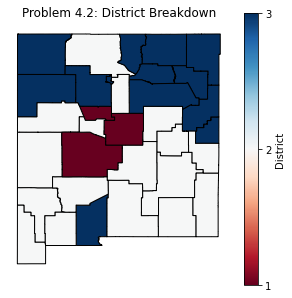

In [80]:
# Plot new districting
d1 = x1.value
d2 = x2.value*2
d3 = x3.value*3
district = d1+d2+d3
geo_df['4.2 District'] = district
plot_map('4.2 District', 'Problem 4.2: District Breakdown', [1,2,3])

In [81]:
# Determine which counties changed from original districting
county_change = np.array(geo_df['4.2 District'] - og_district)
result = np.where(county_change !=0)
print(result)

(array([ 7, 21, 26, 28]),)


In [82]:
# Locate indices provided above
print(df['County'].iloc[7])
print(df['County'].iloc[21])
print(df['County'].iloc[26])
print(df['County'].iloc[28])

Dona Ana
Rio Arriba
Santa Fe
Socorro
